<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/MuRIL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Import required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
file_path = '/content/balanced_dataset.csv'  # Ensure you upload your dataset in Colab
dataset = pd.read_csv(file_path)

# Selecting relevant columns for modeling
data = dataset[['text', 'sentiment_numeric']].copy()

# Splitting the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['sentiment_numeric'], test_size=0.2, random_state=42, stratify=data['sentiment_numeric']
)


In [3]:
# Load the tokenizer for MuRIL
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")

# Tokenize the data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Convert encodings to torch datasets
class KannadaDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = KannadaDataset(train_encodings, list(train_labels))
test_dataset = KannadaDataset(test_encodings, list(test_labels))


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

In [4]:
# Load the MuRIL model
model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=3)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Define metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Train the model using the Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.952700,0.855099,0.657658
2,0.722100,0.797925,0.678250
3,0.611300,0.734939,0.705277


TrainOutput(global_step=585, training_loss=0.7980833917601495, metrics={'train_runtime': 326.2961, 'train_samples_per_second': 28.575, 'train_steps_per_second': 1.793, 'total_flos': 445613406526008.0, 'train_loss': 0.7980833917601495, 'epoch': 3.0})

In [5]:
# Evaluate the model
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_labels.values

# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=sentiment_labels))




Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.77      0.73       259
     Neutral       0.62      0.58      0.60       259
    Positive       0.80      0.76      0.78       259

    accuracy                           0.71       777
   macro avg       0.71      0.71      0.70       777
weighted avg       0.71      0.71      0.70       777



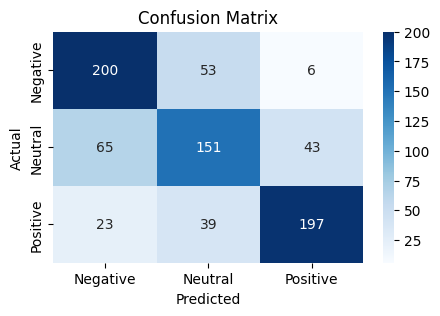

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sentiment_labels,
    yticklabels=sentiment_labels
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [7]:
# Function for sentiment prediction
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Move the model and inputs to the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Get predictions from the model
    outputs = model(**inputs)
    logits = outputs.logits.detach().cpu().numpy()  # Move logits back to CPU for processing
    probabilities = torch.softmax(torch.tensor(logits), dim=1).numpy()[0]
    prediction = np.argmax(probabilities)

    # Sentiment Mapping (Kannada, English)
    sentiment_map = {0: ('ನಕಾರಾತ್ಮಕ', 'Negative'), 1: ('ತಟಸ್ಥ', 'Neutral'), 2: ('ಧನಾತ್ಮಕ', 'Positive')}
    sentiment_kannada, sentiment_english = sentiment_map[prediction]
    confidence = probabilities[prediction]

    return sentiment_kannada, sentiment_english, confidence

# Get input from user
user_input = input("ದಯವಿಟ್ಟು ಕನ್ನಡದಲ್ಲಿ ಒಂದು ವಾಕ್ಯ ನಮೂದಿಸಿ (Please enter a sentence in Kannada): ")
predicted_sentiment_kannada, predicted_sentiment_english, confidence_score = predict_sentiment(user_input)

# Display results
print(f"\nಭಾವನೆ(Sentiment): {predicted_sentiment_kannada}")
print(f"Sentiment (English): {predicted_sentiment_english}")
print(f"ನಂಬಿಕೆ ಸ್ಕೋರ್(Confidence Score): {confidence_score:.2f}")

ದಯವಿಟ್ಟು ಕನ್ನಡದಲ್ಲಿ ಒಂದು ವಾಕ್ಯ ನಮೂದಿಸಿ (Please enter a sentence in Kannada): ಈ ಭಕ್ಷ್ಯವು ಉತ್ತಮ ರುಚಿಯನ್ನು ಹೊಂದಿಲ್ಲ

ಭಾವನೆ(Sentiment): ನಕಾರಾತ್ಮಕ
Sentiment (English): Negative
ನಂಬಿಕೆ ಸ್ಕೋರ್(Confidence Score): 0.72
